# Contexto

Este notebook presenta los procesos para obtener una sabana final para el entrenamiento de un modelo aplicable al challenge de Kaggle "Home Credit - Credit Risk Model Stability". Disponible en:

https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability



## Librerías

In [1]:
import warnings
warnings.filterwarnings("ignore")
from multiprocessing import Pool
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LassoCV
import itertools
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

## Lectura de datos

In [2]:
# Leer información de datos preprocesados

df_train = pd.read_parquet('Data/pre_processed/df_train.parquet')
df_test = pd.read_parquet('Data/pre_processed/df_test.parquet')

## Validaciones iniciales

In [3]:
# Validar que no hayan registros duplicados 

print('Número de registros: '
      , df_train['case_id'].count()
      , 'Número de case id únicos: '
      , df_train['case_id'].drop_duplicates().count()
     )

Número de registros:  1526659 Número de case id únicos:  1526659


(array([84., 36.,  3., 23., 38.,  4., 31., 30., 11.,  4.,  6., 20.,  7.,
        14., 10.,  4.,  2.,  9., 11., 14.]),
 array([ 0.  ,  4.75,  9.5 , 14.25, 19.  , 23.75, 28.5 , 33.25, 38.  ,
        42.75, 47.5 , 52.25, 57.  , 61.75, 66.5 , 71.25, 76.  , 80.75,
        85.5 , 90.25, 95.  ]),
 <BarContainer object of 20 artists>)

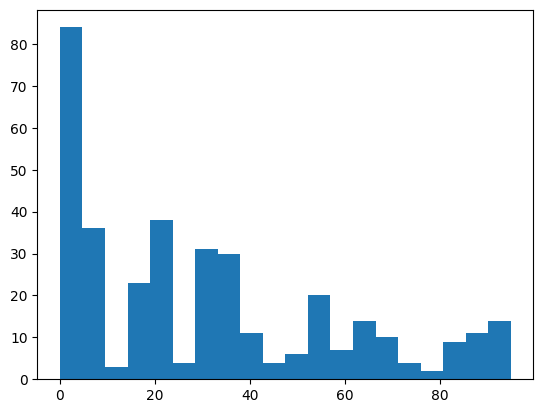

In [4]:
# Missin values por columna

missing_values = df_train.isnull().mean()
missing_values = pd.DataFrame(missing_values).rename(columns={0:'pct_missing'})
missing_values['pct_missing'] = missing_values['pct_missing'].apply(lambda x: round(x*100, 0))

# print(missing_values.sort_values(by = 'pct_missing'
#                                  , ascending=False
#                                 )
#      )

plt.hist(missing_values, bins=20)

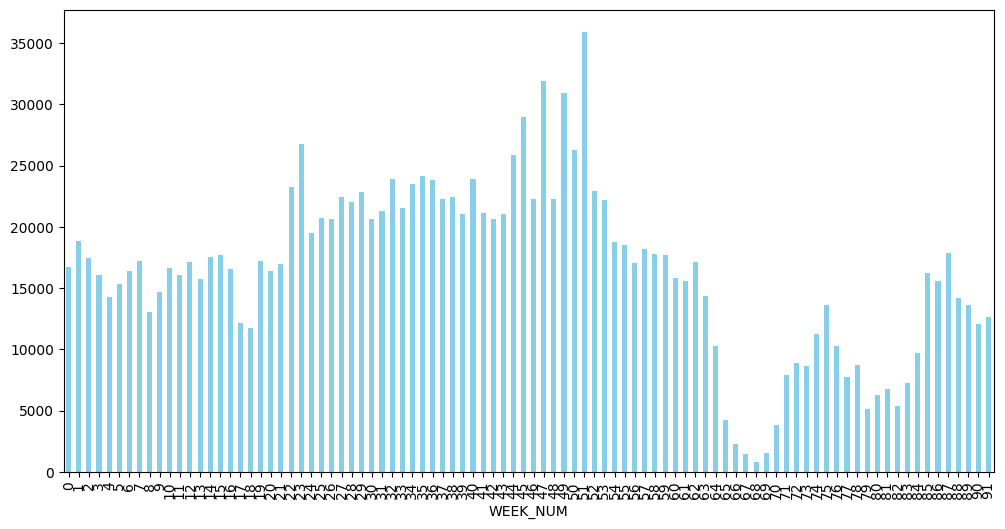

In [5]:
# Validación de continuidad en los datos
weekly_counts = df_train.groupby('WEEK_NUM')['case_id'].agg('count').sort_index()
tick_indices = [0, len(weekly_counts) // 2, len(weekly_counts) - 1]

plt.figure(figsize=(12, 6))
weekly_counts.plot(kind='bar', color='skyblue')

plt.show()


## Preparación de Datos

Primero se seleccionan las variables de tipo identificacion, númericas y categoricas:

In [6]:
all_numerical_columns = df_train.select_dtypes(include=['bool'
                                                        ,'int8'
                                                        ,'int32'
                                                        ,'int64'
                                                        ,'float32'
                                                        ,'float64'
                                                       ]
                                              ).columns

id_columns = list(all_numerical_columns[:3])
num_columns = list(all_numerical_columns[3:])
cat_columns = list(df_train.select_dtypes(include=['category']).columns)

print('Número de columnas id: ' + str(len(id_columns))
      ,'Numero de columnas numéricas: ' + str(len(num_columns))
      ,'Numero de columnas categóricas: ' + str(len(cat_columns))
      ,'Total de columnas: ' + str(len(id_columns) + len(num_columns) + len(cat_columns))
      ,sep = '\n'
     )

Número de columnas id: 3
Numero de columnas numéricas: 295
Numero de columnas categóricas: 63
Total de columnas: 361


Se generan dataset para cada tipo de dato:

In [7]:
for i in ['train', 'test']:
    for j in ['id', 'num', 'cat']:
        if i == 'train':
            exec(f'df_{i}_{j}=df_{i}[{j}_columns].copy()')
        else:
            exec(f"df_{i}_{j}=df_{i}[[x for x in {j}_columns if x != 'target']].copy()")

Luego se realiza validación de columnas numéricas, eliminando las que tengan demasiados valores nulos dependiendo el número de valores únicos intuyendo alguna variable categórica:

In [8]:
null_percentage = df_train_num.isnull().mean()*100
unique_values_count = df_train_num.nunique()
min_value = df_train_num.min()
max_value = df_train_num.max()

null_unique_df = pd.DataFrame({'null_percentage': null_percentage
                               , 'unique_values_count': unique_values_count
                               , 'min_value': min_value.apply(lambda x: int(x))
                               , 'max_value': max_value.apply(lambda x: int(x))
                              }
                             )

null_unique_df['max_min'] = null_unique_df['max_value'] - null_unique_df['min_value']
null_unique_df['flg_col_cat'] = null_unique_df.apply(lambda x: 1 if ((x.unique_values_count*1.5)>=x.max_min) & (x.unique_values_count <= 24) else 0
                                                     ,axis = 1
                                                    )
null_unique_df['flg_null_menor_50'] = null_unique_df.apply(lambda x: 1 if (x.null_percentage<0.5) & (x.flg_col_cat==0) else 0
                                                           ,axis = 1
                                                           )

cols_sel_cat_df = list(null_unique_df[(null_unique_df['flg_col_cat']==1)].index) # Variables categoricas en formato numérico a imputar con constante
cols_sel_num_df = list(null_unique_df[(null_unique_df['flg_null_menor_50']==1)].index) # Variables a imputar con KNN

# Seleccionar solo columnas que pasan algun flag

df_train_num = df_train_num[cols_sel_cat_df + cols_sel_num_df]

# Imputar categoricas camufladas con el valor anterior al mínimo

for i in cols_sel_cat_df:
    df_train_num[i] = df_train_num[i].fillna(min(df_train_num[~df_train_num[i].isna()][i])-1).astype('category')

# Imputar numéricas con KNN

for i in cols_sel_num_df:
    imputer = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=11), max_iter=10, random_state=42)
    df_train_num[[i]] = imputer.fit_transform(df_train_num[[i]])
    df_test_num[[i]] = imputer.fit_transform(df_test_num[[i]])

Para las variables categoricas restantes se genera una nueva categoria llamada NA para cada una:

In [9]:
for i in cat_columns:
    df_train_cat[i] = df_train_cat[i].cat.add_categories('NA').fillna('NA')
    df_test_cat[i] = df_test_cat[i].astype('category').cat.add_categories('NA').fillna('NA')

Se unen los datasets y se realiza una imputacion de las variables categoricas con NA:

In [10]:
for i in ['train', 'test']:
    exec(f'df_{i}=pd.concat([df_{i}_id, df_{i}_num, df_{i}_cat], axis = 1)')

Se vuelven a generar la clasificacion por tipos de columna:

In [11]:
all_numerical_columns = df_train.select_dtypes(include=['bool'
                                                        ,'int8'
                                                        ,'int32'
                                                        ,'int64'
                                                        ,'float32'
                                                        ,'float64'
                                                       ]
                                              ).columns

id_columns = list(all_numerical_columns[:3])
num_columns = list(all_numerical_columns[3:])
cat_columns = list(df_train.select_dtypes(include=['category']).columns)

print('Número de columnas id: ' + str(len(id_columns))
      ,'Numero de columnas numéricas: ' + str(len(num_columns))
      ,'Numero de columnas categóricas: ' + str(len(cat_columns))
      ,'Total de columnas: ' + str(len(id_columns) + len(num_columns) + len(cat_columns))
      ,sep = '\n'
     )

for i in ['train', 'test']:
    for j in ['id', 'num', 'cat']:
        if i == 'train':
            exec(f'df_{i}_{j}=df_{i}[{j}_columns].copy()')
        else:
            exec(f"df_{i}_{j}=df_{i}[[x for x in {j}_columns if x != 'target']].copy()")

Número de columnas id: 3
Numero de columnas numéricas: 32
Numero de columnas categóricas: 120
Total de columnas: 155


## Seleccion Variables Númericas

Primero se eliminan las variables muy correlacionadas entre sí:

In [12]:
corr_matrix = df_train_num.corr()
threshold = 0.8

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

df_train_num = df_train_num.drop(columns=to_drop)
df_train_num.shape

(1526659, 24)

Luego se seleccionan las variables a partir de regularización Lasso L1:

In [13]:
X = df_train_num
y = df_train['target']

lasso = LassoCV(cv=5, random_state=42).fit(X, y)

selected_features = np.where(lasso.coef_ != 0)[0]
selected_columns = X.columns[selected_features]

df_train_num = df_train_num[selected_columns]
df_test_num = df_test_num[selected_columns]
len(selected_columns)

6

Se escalan los valores de seleccionados con min max:

In [14]:
scaler = MinMaxScaler()

df_train_num = pd.DataFrame(scaler.fit_transform(df_train_num), columns = selected_columns)
df_test_num = pd.DataFrame(scaler.transform(df_test_num), columns = selected_columns)

## Seleccion Variables Cualitativas

Para este caso se revisan los relacionamientos y la independencia

In [15]:
cramer_chi2_df = pd.read_parquet('Metadata/cramer_chi_baja_cardinalidad_df.parquet')

# Se toman las columnas netamente independientes
significancia = 0.05
col_cat_independientes = list(cramer_chi2_df.groupby('Columna_1')['Valor_P_Chi2'].max().where(lambda x: x>significancia).dropna().index)

# Se eliminan dichas columnas del dataset de pares
cramer_chi2_df = cramer_chi2_df[~((cramer_chi2_df['Columna_1'].isin(col_cat_independientes)) | (cramer_chi2_df['Columna_2'].isin(col_cat_independientes)))]

# Se filtran todos los pares con un relacionamiento fuerte
cramer_corte = 0.15
cramer_chi2_df = cramer_chi2_df[cramer_chi2_df['Coeficiente_Cramer'] > cramer_corte]

# Se generan las columnas que se deben estudiar
col_cat_dependientes = np.unique(np.concatenate([cramer_chi2_df['Columna_1'].unique(), cramer_chi2_df['Columna_2'].unique()]))

In [16]:
# Se entrena un modelo rf dummy con todas las variables categoricas para obtener la importancia
X_cat = pd.get_dummies(df_train_cat[col_cat_dependientes])
y = df_train['target']

In [17]:
model_rf = joblib.load('Modelos/rf_dependent_variables_selection.joblib')

# Se agregan todas las importancias por columna
feature_importances = pd.Series(model_rf.feature_importances_, index=X_cat.columns)

categorical_importances = {}
for col in col_cat_dependientes:
    col_importances = feature_importances[X_cat.columns.str.startswith(col + '_')].sum()
    categorical_importances[col] = col_importances

# Por relacion se marca la columna de mayor importancia

cramer_chi2_df['Importancia_1'] = cramer_chi2_df.apply(lambda x: categorical_importances[x.Columna_1]
                                                       ,axis = 1
                                                      )
cramer_chi2_df['Importancia_2'] = cramer_chi2_df.apply(lambda x: categorical_importances[x.Columna_2]
                                                       ,axis = 1
                                                      )

cramer_chi2_df['Columna_Rechazada'] = cramer_chi2_df.apply(lambda x: x.Columna_1 if x.Importancia_1 < x.Importancia_2
                                                           else x.Columna_2
                                                           ,axis = 1
                                                           )

cramer_chi2_df = cramer_chi2_df[~cramer_chi2_df['Columna_1'].isin(list(cramer_chi2_df['Columna_Rechazada'].unique()))]

# Se toman las columnas dependientes seleccionadas

col_cat_dependientes = list(cramer_chi2_df['Columna_1'].unique())

Se toman así las columnas seleccionadas más las de alta cardinalidad:

In [18]:
cat_columns_alta_cardinalidad = [col for col in cat_columns if df_train_cat[col].nunique() > 10]
cat_columns = col_cat_independientes + col_cat_dependientes + cat_columns_alta_cardinalidad
df_train_cat = df_train_cat[cat_columns]

Se repite el proceso incluyendo las columnas de alta cardinalidad

In [19]:
cramer_chi2_df = pd.read_parquet('Metadata/cramer_chi_total.parquet')

# Se toman las columnas netamente independientes
significancia = 0.05
col_cat_independientes = list(cramer_chi2_df.groupby('Columna_1')['Valor_P_Chi2'].max().where(lambda x: x>significancia).dropna().index)

# Se eliminan dichas columnas del dataset de pares
cramer_chi2_df = cramer_chi2_df[~((cramer_chi2_df['Columna_1'].isin(col_cat_independientes)) | (cramer_chi2_df['Columna_2'].isin(col_cat_independientes)))]

# Se filtran todos los pares con un relacionamiento fuerte
cramer_corte = 0.15
cramer_chi2_df = cramer_chi2_df[cramer_chi2_df['Coeficiente_Cramer'] > cramer_corte]

# Se generan las columnas que se deben estudiar
col_cat_dependientes = np.unique(np.concatenate([cramer_chi2_df['Columna_1'].unique(), cramer_chi2_df['Columna_2'].unique()]))

In [20]:
# Se entrena un modelo rf dummy con todas las variables categoricas para obtener la importancia
X_cat = pd.get_dummies(df_train_cat[col_cat_dependientes])
y = df_train['target']

In [21]:
model_rf = joblib.load('Modelos/rf_dependent_total_variables_selection.joblib')

# Se agregan todas las importancias por columna
feature_importances = pd.Series(model_rf.feature_importances_, index=X_cat.columns)

categorical_importances = {}
for col in col_cat_dependientes:
    col_importances = feature_importances[X_cat.columns.str.startswith(col + '_')].sum()
    categorical_importances[col] = col_importances

# Por relacion se marca la columna de mayor importancia

cramer_chi2_df['Importancia_1'] = cramer_chi2_df.apply(lambda x: categorical_importances[x.Columna_1]
                                                       ,axis = 1
                                                      )
cramer_chi2_df['Importancia_2'] = cramer_chi2_df.apply(lambda x: categorical_importances[x.Columna_2]
                                                       ,axis = 1
                                                      )

cramer_chi2_df['Columna_Rechazada'] = cramer_chi2_df.apply(lambda x: x.Columna_1 if x.Importancia_1 < x.Importancia_2
                                                           else x.Columna_2
                                                           ,axis = 1
                                                           )

cramer_chi2_df = cramer_chi2_df[~cramer_chi2_df['Columna_1'].isin(list(cramer_chi2_df['Columna_Rechazada'].unique()))]

# Se toman las columnas dependientes seleccionadas

col_cat_dependientes = list(cramer_chi2_df['Columna_1'].unique())

Se toman así las columnas seleccionadas y se generan la informacion categórica final:

In [22]:
cat_columns = col_cat_independientes + col_cat_dependientes
df_train_cat = df_train_cat[cat_columns]
len(cat_columns)

53

In [23]:
# Se realiza one hot encoding para las columnas resultantes

df_train_cat = df_train[cat_columns]
df_test_cat = df_test[cat_columns]

encoder = OneHotEncoder(handle_unknown='ignore')
ct = ColumnTransformer([('encoder', encoder, cat_columns)], remainder='passthrough')

df_train_cat_transformed = ct.fit_transform(df_train_cat)
df_test_cat_transformed = ct.transform(df_test_cat)

feature_names = ct.get_feature_names_out()
df_train_cat = pd.DataFrame.sparse.from_spmatrix(df_train_cat_transformed, columns=feature_names)
df_test_cat = pd.DataFrame.sparse.from_spmatrix(df_test_cat_transformed, columns=feature_names)

df_train_cat.shape

(1526659, 1462)

Posteriormente se eliminan columnas que no sean significativas para la poblacion:

In [24]:
threshold_significance = 0.05

to_drop = []
for column in df_train_cat.columns:
    proporcion = df_train_cat[column].value_counts(normalize=True).min()
    if proporcion < threshold_significance:
        to_drop.append(column)

df_train_cat = df_train_cat.drop(columns=to_drop)
df_test_cat = df_test_cat.drop(columns=to_drop)

df_train_cat.shape

(1526659, 148)

Convertir columnas de sparse a dense:

In [25]:
df_train_cat = df_train_cat.apply(lambda x: x.sparse.to_dense())
df_test_cat = df_test_cat.apply(lambda x: x.sparse.to_dense())

## Selección Conjunta

Se concatenan los datasets de variables numéricas y categóricas:

In [26]:
for i in ['train', 'test']:
    exec(f'df_{i}_pre=pd.concat([df_{i}_num, df_{i}_cat], axis = 1)')
    exec(f'del [df_{i}_num, df_{i}_cat]')

Se seleccionan las columnas que finalmente no estan correlacionadas entre sí y regularizando quitando caracterisitcas que no aportan

In [27]:
corr_matrix = df_train_pre.corr()
threshold = 0.8

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

df_train_pre = df_train_pre.drop(columns=to_drop)
df_train_pre.shape

(1526659, 123)

In [28]:
X = df_train_pre
y = df_train['target']

lasso = LassoCV(cv=5, random_state=42).fit(X, y)

selected_features = np.where(lasso.coef_ != 0)[0]
selected_columns = X.columns[selected_features]

df_train_pre = df_train_pre[selected_columns]
df_test_pre = df_test_pre[selected_columns]
len(selected_columns)

118

## Sabana Final

Se concatenan los datasets de variables de ids, numéricas y categóricas:

In [29]:
for i in ['train', 'test']:
    exec(f'df_{i}=pd.concat([df_{i}_id, df_{i}_pre], axis = 1)')
    exec(f'del [df_{i}_id, df_{i}_pre]')

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [30]:
df_train.shape

(1526659, 121)

In [31]:
# Datos de Salida
df_train.to_pickle('Data/processed/df_train.pkl')
df_test.to_pickle('Data/processed/df_test.pkl')